# Assignment 2: Cost-Aware A/B Testing

## Background

A/B testing (a.k.a. randomized controlled trials, randomized experiments) is one of the most important ways to understand causal relationships. In a typical A/B testing setup, there will be one (or more) treatment group and one control group, and a pool of subjects are randomly assigned to the experimental groups based on pre-determined proportions (e.g., equal assignments). 

While this is a perfectly legitimate way to test causality, it can be inefficient in practice. Imagine a clinical trial of two treatment options: drug A and placebo B, and let's assume that (in fact) drug A is much more effective than placebo B in treating a certain condition. Then, every subject that is assigned to the placebo group has to (unfortunately) endure some non-trivial costs, i.e., their conditions are not treated timely even when an effective drug exists. Note that some of the costs are necessary - after all, we don't know the effectiveness of drug A a priori and need a sufficient number of people in both groups to find out. However, as the effectiveness of drug A becomes clearer and clearer over the course of the experiment, perhaps it makes sense to gradually reduce the assignment to the placebo group, in order to reduce costs. 

This is the basic idea behind **cost-aware A/B testing**. It is an important emerging topic in experimentation, and has attracted a lot of attention from both researchers and practitioners.

## Cost Aware A/B testing


In [255]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

**Problem at hand:**
We are interesting in A/B testing across multiple treatment options under a trial. Each of the 𝑘 treatments has a true underlying treatment effect {𝑇𝐸1,…,𝑇𝐸𝑘}. There are 𝑁 subjects available in total, who can be assigned to the different treatment groups. The goal of the experimenter is twofold: 
1. The experimenter wants to understand the effectiveness of each treatment option (this is why the experiment is conducted in the first place)
2. The experimenter wants to be cost-aware in treatment assignment and try to avoid incurring too much costs.

**As a reinforcement learning problem, this translates to the following objective:**
1. Having enough patients in each treatment to best estimating each treatment's effect (Exploration)
2. Once confident with good treatments, more patients should be assigned to these treatments (Exploitation)

**Here we define the elements of RL:**
* Agent: The experimenter who wants to know which treaments to assign how many patients to
* Environment: The various treatments and pateints available for the test as a whole comprise the environment
* Action: Assigning a patient i to a treatment j
* Reward: A treatment j's outcome on a particular patient i

**First we are interesting in estimating the average teatment effect for each treatment, given by**
$$Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \mathbb{1}_{A_i = a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i = a}}$$

**Apart from loking at average treatment effect, a common statistic to consider for A/B tseting especially in the clinical trial setting is to look at the confidnce interval.**
* Confidnce interval is given by the equation below.
* For any given confidence level, the interval is controlled by the s/sqrt(n) factor.
* As this factor increases, more is the C.I and less certain are we with our estimates.
* Although there are multiple statistics to measure uncertainty for causal inference (like p-value), the simplest and most appropriate in this context would be **s / sqrt(n)**

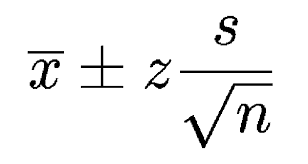

In [256]:
# Let's consider a 15 different treatments and 5000 patients avaiable for the test
k = 15
N = 5000
# Simulating k treatments with unknown mean (treatment effect) and variance (error)
np.random.seed(69)
true_rewards = np.random.normal(size = k)
true_variance = np.absolute(np.random.normal(size = k))
print(true_rewards)
print(f"Average reward is {np.mean(true_rewards)}, Best arm reward is {max(true_rewards)}, Best arm is {np.argmax(true_rewards)}.")
print("\n")
print(true_variance)
print(f"Average variance is {np.mean(true_variance)}, Least arm variance is {min(true_variance)}, Best arm is {np.argmin(true_variance)}.")

[ 0.9155071  -0.60354197  1.16229517 -0.60140014 -1.59748566  0.39772612
  1.20586542  1.05629911  0.85254391  0.68939141 -0.22473706 -0.52218217
 -0.84007163  1.18058312 -1.32884084]
Average reward is 0.116130126002743, Best arm reward is 1.2058654248762246, Best arm is 6.


[0.12439675 0.4974814  1.94712335 1.84865498 0.26466031 0.9345718
 1.16996432 0.73960539 1.11215464 1.98192696 1.19387174 0.16862644
 2.09861293 0.01915532 0.30218571]
Average variance is 0.9601994694036073, Least arm variance is 0.019155324040148837, Best arm is 13.


In [257]:
# Defining a function to pull random value for each treatment. Here the mean and variance are from above simulation.
def pull(arm_ind):
    return np.random.normal(loc = true_rewards[arm_ind], scale = true_variance[arm_ind])

pull(6)

0.08225225588318086

In [258]:
# Incrementing value estimation and error estimation
def value_est(curr_values, error_values, all_rewards_arm, counter, action, reward):
    # curr_values stores the current estimate of Q_t(a)
    curr_values[action] = (curr_values[action]*counter[action] + reward) / (counter[action] + 1)
    # Update uncertainty values for the treatment as s/sqrt(n)
    error_values[action] = np.std(all_rewards_arm) / np.sqrt(counter[action] + 1)
    # Incrementing counter for each treatment
    counter[action] += 1
    return curr_values, error_values, counter

In [259]:
# Implementing softmax function
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [260]:
# This function returns all the rewards for a given arm till time step 't'
def rewards_arm(x, y, arm):
    return y[np.where(x == arm)]

### Epsilon Greedy

* The approach used here is to alter the Epsilon probability depending upon the error / uncertainty associated with each arm up until that time step

$$E(a) = soft\max_a (errors)$$

where a softmax is calculated using errors of all arms and the error associated with the arm that has the best average estimate Qa(t) is picked

* The intuition behind doing so is, if an arm has large errors even if it has the best average value estimate - we force the algorithm to explore more

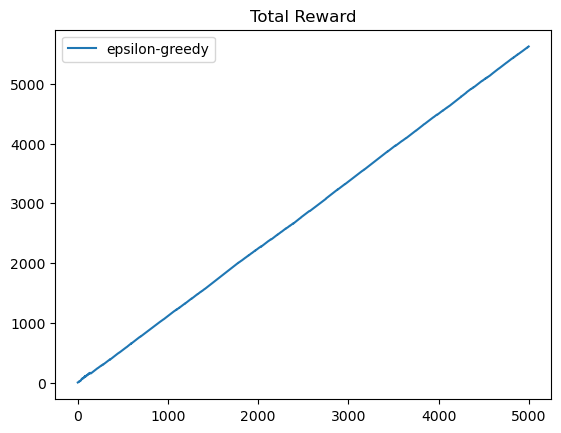

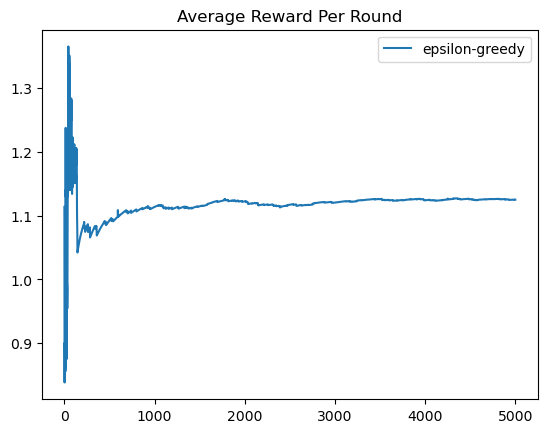

In [261]:
# Epsilon-Greedy strategy
curr_values = [0]*k  # initial values
counter = [0]*k  # initialize counter
error_values = [0]*k # initialize errors
reward_greedy_eps = np.empty(0)
reward_greedy_eps_arms = np.empty(0)
sumreward_greedy_eps = []
avereward_greedy_eps = []
for t in range(N):
    # current best arm
    arm = np.argmax(curr_values)
    # Vary epsilon based on uncertainty of the best arm
    eps = softmax(error_values)[arm]
    
    explore = np.random.binomial(1, eps)
    if explore:
        # randomly pull another arm
        arm = np.random.choice(np.setdiff1d(range(k), arm))
    reward = pull(arm)
    reward_greedy_eps_arms = np.append(reward_greedy_eps_arms, arm)
    reward_greedy_eps = np.append(reward_greedy_eps, reward)
    
    #Pick all historic rewards for the current arm to adjust standard error
    all_rewards_arm = rewards_arm(reward_greedy_eps_arms, reward_greedy_eps, arm)
    # update curr_values and error_values
    curr_values, error_values, counter = value_est(curr_values, error_values, all_rewards_arm, counter, arm, reward)

    # record sum and average reward up to this round
    sumreward_greedy_eps.append(np.sum(reward_greedy_eps))
    avereward_greedy_eps.append(np.mean(reward_greedy_eps))
    
# Let's plot the sum and average reward over 1000 rounds
plt.plot(sumreward_greedy_eps)
plt.title("Total Reward")
plt.legend(["epsilon-greedy"])
plt.show()

plt.plot(avereward_greedy_eps)
plt.title("Average Reward Per Round")
plt.legend(["epsilon-greedy"])
plt.show()

In [262]:
# Checking all the average treatment effect estimates and correspoding standard errors
print(curr_values)
print("\n")
print(error_values)
print("\n")
print(counter)

[0.927918473570168, -0.6348764077733621, 1.0650026548172393, -1.3477503933497668, -1.727906747357153, 0.400034639070107, 1.138408916961222, 0.8812303860166866, 0.8996652558588203, 1.0884306209197911, -0.2720645503773872, -0.48401986213000836, 0.15015183780470895, 1.1800902016343606, -1.418774973481367]


[0.026691978490553724, 0.09568606502078418, 0.17857150380958142, 0.44460373141042414, 0.0659259905872696, 0.18287722317898417, 0.18746107149697466, 0.12279685364902478, 0.2708375434054622, 0.37082917173653407, 0.3120762988170692, 0.02910914431441974, 0.5605116376414917, 0.00027900255653967094, 0.0464262456827127]


[33, 15, 137, 21, 13, 23, 39, 14, 13, 27, 17, 14, 17, 4602, 15]


In [263]:
# Calculating error in estimation
print(mean_squared_error(true_rewards,curr_values, squared = True) * 100)

11.824231501822252


In [264]:
print(np.sum(counter * np.where(true_rewards < 0, 1, 0)))

112


* Each treatment has been given to atleast 13 patients.
* We have estimated the treatment effects with an RMSE of 11%
* 112 patients out of 5000 were assigned to depreciative treatments

### UCB

* In UCB, the action we take is given by the equation

$$A_t = \arg\max_a \left\{Q_t(a) + c \cdot \sqrt{\frac{\ln t}{N_t(a)}} \right\}$$

where c controls the aggressiveness of exploration. Similar to epsilon-greedy, we can control the exploartion based on uncertainty of a particular treatment

* Here, c is given by $$c(a) = soft\max_a (errors) * scaling constant$$ 

The scaling constant can be decided based upon the scale difference between Q_t(a) and error terms (Kept as 25 here)


In [265]:
# let's define a function to calculate the adjusted values under UCB
def ucb_calc(curr_values, t, counter, c):
    ucb_values = [0]*len(curr_values)
    for i in range(k):
        if counter[i] == 0:
            ucb_values[i] = curr_values[i] + 9999.99
        else:
            ucb_values[i] = curr_values[i] + c * np.sqrt(np.log(t) / counter[i])
    return ucb_values

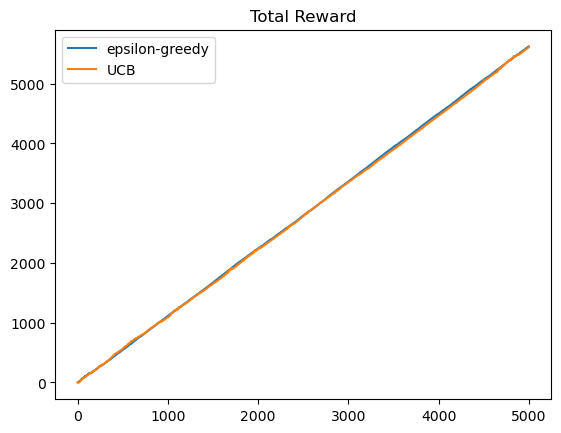

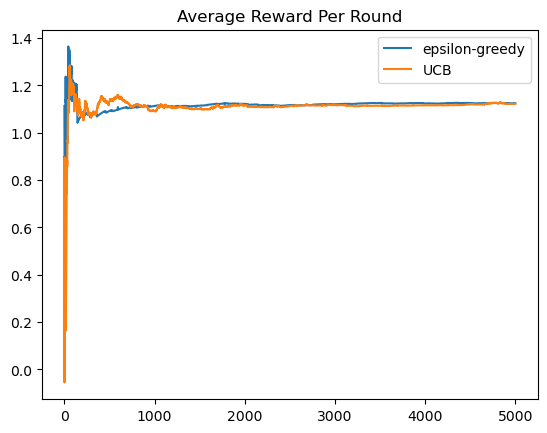

In [266]:
# UCB
curr_values = [0]*k  # initial values
counter = [0]*k  # initialize counter
error_values = [0]*k # initialize errors
explore_scaling = 25 # exploration scaling defines the amount to scale the c values
reward_ucb = np.empty(0)
reward_ucb_arms = np.empty(0)
sumreward_ucb = []
avereward_ucb = []
for t in range(N):
    # Vary c based on uncertainty of the best arm and add a scaling constant
    c = softmax(error_values)[arm] * explore_scaling
    
    # do the UCB value adjustments
    ucb_values = ucb_calc(curr_values, t+1, counter, c)
    # current best arm
    arm = np.argmax(ucb_values)    
    reward = pull(arm)
    
    # record sum and average reward up to this round
    reward_ucb_arms = np.append(reward_ucb_arms, arm)
    reward_ucb = np.append(reward_ucb, reward)
    
    #Pick all historic rewards for the current arm to adjust standard error
    all_rewards_arm = rewards_arm(reward_ucb_arms, reward_ucb, arm)
    # update curr_values
    curr_values, error_values, counter = value_est(curr_values, error_values, all_rewards_arm, counter, arm, reward)
    sumreward_ucb.append(np.sum(reward_ucb))
    avereward_ucb.append(np.mean(reward_ucb))
    

    
# Let's plot the sum and average reward over 1000 rounds
plt.plot(sumreward_greedy_eps)
plt.plot(sumreward_ucb)
plt.title("Total Reward")
plt.legend(["epsilon-greedy", "UCB"])
plt.show()

plt.plot(avereward_greedy_eps)
plt.plot(avereward_ucb)
plt.title("Average Reward Per Round")
plt.legend(["epsilon-greedy", "UCB"])
plt.show()

In [267]:
# Checking all the average treatment effect estimates and correspoding standard errors
print(curr_values)
print("\n")
print(error_values)
print("\n")
print(counter)

[0.9111290546579246, -0.6528407088924808, 1.125145649505366, -0.0014564055695217874, -1.5940524957097484, 0.5130144989563316, 1.1560811523019792, 1.0710210762687742, 0.7115002540620565, 0.13155851523748072, -0.5899681504128481, -0.5405455217001028, -1.027883754792385, 1.1806431932145187, -1.1821535319007257]


[0.011833171896482704, 0.09519084723939361, 0.06969157201059507, 0.266918507299411, 0.09489048815274012, 0.11512146999459238, 0.032219649982759384, 0.037736917186557445, 0.16446696649373163, 0.37751183183041076, 0.5754001162065406, 0.05491015259880082, 1.1886754387112999, 0.0004092712299446186, 0.04989514835330724]


[125, 6, 790, 11, 3, 33, 1310, 403, 58, 15, 6, 6, 5, 2225, 4]


In [268]:
# Calculating error in estimation
print(mean_squared_error(true_rewards,curr_values, squared = True) * 100)

6.009019250739663


In [269]:
print(np.sum(counter * np.where(true_rewards < 0, 1, 0)))

41


* Each treatment has been given to atleast 3 patients.
* We have estimated the treatment effects with an RMSE of 6%
* Only 41 patients out of 5000 were assigned to depreciative treatments

**Conclusion:**  
1. In both the approaches, we have given priority to the arm that had second best average treatment effect and the lowest variance in treatment effect.  


2. UCB is more appropriate in this context as it gives:
* Lesser RMSE of treatment effect estimation
* Lower cost of mistreating patients
* More flexible parameters to control

3. Other Action-value approaches like Greedy are not suitable for clinical trial testing as more exploration is required to better estimate the average treatment effects.